In [82]:
import numpy as np
import pandas as pd 
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="dark")
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing
from sklearn import metrics
from sklearn. metrics import confusion_matrix
import cv2
import glob
import os
import warnings as wr
wr.filterwarnings("ignore")


In [83]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [84]:
train_path=r'/content/drive/MyDrive/archive_2/Train/Train/JPEGImages'
train_annot=r'/content/drive/MyDrive/archive_2/Train/Train/Annotations'

test_path=r'/content/drive/MyDrive/archive_2/Test/Test/JPEGImages'
test_annot=r'/content/drive/MyDrive/archive_2/Test/Test/Annotations'

val_path=r'/content/drive/MyDrive/archive_2/Val/Val/JPEGImages'
val_annot=r'/content/drive/MyDrive/archive_2/Val/Val/Annotations'





In [85]:
def creatingInfoData(Annotpath):
    information={'xmin':[],'ymin':[],'xmax':[],'ymax':[],'name':[]
                ,'label':[]}

    for file in sorted(glob.glob(str(Annotpath+'/*.xml*'))):
        dat=ET.parse(file)
        for element in dat.iter():    

            if 'object'==element.tag:
                for attribute in list(element):
                    if 'name' in attribute.tag:
                        name = attribute.text                 
                        information['label'] += [name]
                        information['name'] +=[file.split('/')[-1][0:-4]]

                    if 'bndbox'==attribute.tag:
                        for dim in list(attribute):
                            if 'xmin'==dim.tag:
                                xmin=int(round(float(dim.text)))
                                information['xmin']+=[xmin]
                            if 'ymin'==dim.tag:
                                ymin=int(round(float(dim.text)))
                                information['ymin']+=[ymin]
                            if 'xmax'==dim.tag:
                                xmax=int(round(float(dim.text)))
                                information['xmax']+=[xmax]
                            if 'ymax'==dim.tag:
                                ymax=int(round(float(dim.text)))
                                information['ymax']+=[ymax]
                     
    return pd.DataFrame(information)

In [86]:
train_info=creatingInfoData(train_annot)
test_info=creatingInfoData(test_annot)
val_info=creatingInfoData(val_annot)

In [87]:
train_info.head(20)

,xmin,ymin,xmax,ymax,name,label
0,158,44,289,167,image (1),person
1,185,56,287,241,image (10),person
2,2,86,344,374,image (100),person
3,220,95,500,290,image (100),person
4,13,110,213,375,image (101),person
5,149,127,355,375,image (101),person
6,292,61,500,375,image (101),person
7,1,19,335,338,image (102),person
8,261,23,500,338,image (102),person
9,77,46,202,464,image (103),person


In [88]:
train_info.loc[train_info['name']=='image (101)']

,xmin,ymin,xmax,ymax,name,label
4,13,110,213,375,image (101),person
5,149,127,355,375,image (101),person
6,292,61,500,375,image (101),person


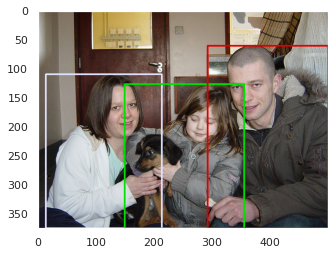

In [89]:
img=cv2.imread(train_path+'/image (101).jpg',cv2.IMREAD_COLOR)
img=cv2.cvtColor(img,cv2.COLOR_BGRA2RGB)

cv2.rectangle(img,(13,110),(213,375),(225,225,255),2)
cv2.rectangle(img,(149,127),(355,375),(0,225,0),2)
cv2.rectangle(img,(292,61),(500,375),(225,0,0),2)

plt.imshow(img)

In [90]:
def croppingFromImage(path,Data_information):
    cropped_image=[]
    label=[]
    for i in range(0,len(Data_information)):
        img=cv2.imread(path+'/'+Data_information['name'][i]+'.jpg',cv2.IMREAD_COLOR)
        img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
        img_=img[Data_information['ymin'][i]:Data_information['ymax'][i],Data_information['xmin'][i]:Data_information['xmax'][i]]
        cropped_image.append(img_)
        label.append(Data_information['label'][i])
    return cropped_image , label

In [91]:
trainImage , trainLabel =croppingFromImage(train_path,train_info)
testImage , testLabel =croppingFromImage(test_path,test_info)
valImage , valLabel=croppingFromImage(val_path,val_info)

In [92]:
print(len(trainImage) == len(trainLabel))
print(len(testImage) == len(testLabel))
print(len(valImage) == len(valLabel))

True
True
True


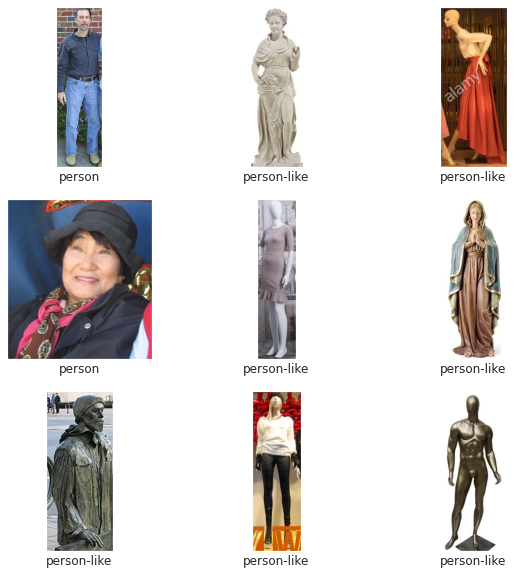

In [93]:
fig=plt.figure(figsize=(10,10))

for i in range (1,10):
    random=np.random.randint(0,len(trainImage))
    plt.subplot(3,3,i)
    plt.imshow(trainImage[random])
    
    plt.xlabel(trainLabel[random])
    plt.xticks([])
    plt.yticks([])

In [94]:
trainShapes=[]
testShapes=[]
for i in trainImage :
    trainShapes.append(i.shape)
for i in testImage :
    testShapes.append(i.shape)

In [95]:
pd.Series(trainShapes).value_counts()[:10]

(374, 499, 3)    4
(162, 58, 3)     2
(280, 252, 3)    2
(151, 60, 3)     2
(358, 271, 3)    2
(95, 43, 3)      2
(44, 34, 3)      2
(101, 49, 3)     2
(101, 32, 3)     2
(284, 92, 3)     2
dtype: int64

In [96]:
pd.Series(testShapes).value_counts()[:10]

(85, 52, 3)      2
(128, 58, 3)     2
(128, 47, 3)     2
(120, 37, 3)     2
(171, 74, 3)     2
(105, 81, 3)     2
(506, 449, 3)    1
(225, 128, 3)    1
(180, 94, 3)     1
(187, 85, 3)     1
dtype: int64

In [97]:
def resizing(data,size):
    resizing=[]
    for i in data:
        resizing.append(cv2.resize(i,(size,size)))
        
    return resizing

In [98]:
s=140
X_train,X_test,X_Val=resizing(trainImage,s),resizing(testImage,s),resizing(valImage,s)

LabelEncoder

In [99]:
labeling=preprocessing.LabelEncoder()
y_train=labeling.fit_transform(trainLabel)
y_test=labeling.fit_transform(testLabel)
y_val=labeling.fit_transform(valLabel)

In [100]:
labeling.classes_

array(['person', 'person-like'], dtype='<U11')


Feature Extraction VGG-16

In [101]:
VGG_Model=VGG16(weights='imagenet',include_top=False,input_shape=(s,s,3))

In [102]:
for layer in VGG_Model.layers:
    layer.trainable=False

In [103]:
VGG_Model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 140, 140, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 140, 140, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 140, 140, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 70, 70, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 70, 70, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 70, 70, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 35, 35, 128)       0     

Normalizaton

In [104]:
X_train,X_test,X_Val=np.asarray(X_train).astype(np.float32),np.asarray(X_test).astype(np.float32),np.asarray(X_Val).astype(np.float32)
x_train,x_test,x_Val=X_train/255.0,X_test/255.0,X_Val/255.0

In [105]:
Training=np.concatenate((X_train,X_test))
Training_lbl=np.concatenate((y_train,y_test))

In [106]:
features_extracted=VGG_Model.predict(Training)
features_extracted_test=VGG_Model.predict(X_Val)

In [107]:
flatten=features_extracted.reshape(features_extracted.shape[0],-1)
flatten_test=features_extracted_test.reshape(features_extracted_test.shape[0],-1)

Training with RandomForestClassifier

In [108]:
RF_Model = RandomForestClassifier(n_estimators=50 , random_state=42)
RF_Model.fit(flatten,Training_lbl)
prediction_Rf = RF_Model.predict(flatten_test)

Accuracy

In [109]:
print('Accuracy = ' ,metrics. accuracy_score (y_val, prediction_Rf))

Accuracy =  0.8108108108108109


In [110]:
cm = confusion_matrix(y_val, prediction_Rf)
print (cm)

[[165  38]
 [ 25 105]]


In [163]:
def conver(prediction):
    if (prediction > 0):return 'Not person'
    else:return 'person'

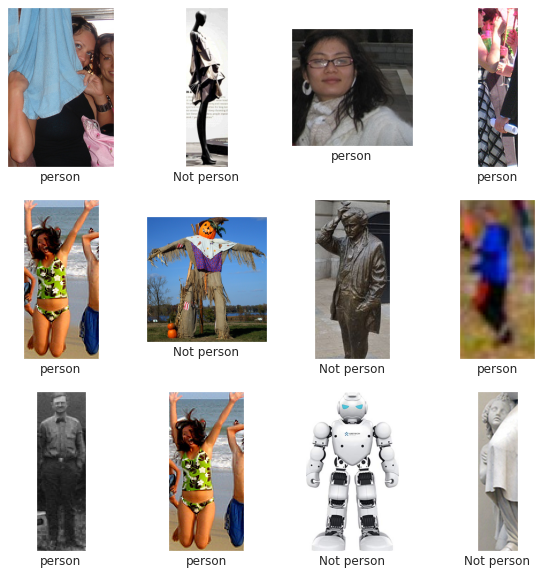

In [164]:
fig=plt.figure(figsize=(10,10))

for i in range (1,13):
    random=np.random.randint(0,len(valImage))
    plt.subplot(3,4,i)
    plt.imshow(valImage[random])
    label=conver(y_val[random])
    plt.xlabel(label)
    plt.xticks([])
    plt.yticks([])

Training with tensoreflow layers

In [180]:
model=Sequential()
model.add(Dense(64,input_shape=flatten.shape))
model.add(Activation('relu'))
model.add(Dropout(.7))
model.add(Dense(2))
model.add(Activation('sigmoid'))

In [181]:
# model.compile(optimizer='adam',
#               loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#               metrics=['accuracy'])

In [186]:
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [193]:
flatten = flatten.reshape(2661, 8192)
fitting = model.fit(flatten,Training_lbl,batch_size=100,epochs=7,validation_data=(flatten_test,y_val))

Epoch 1/7


ValueError: ignored

In [ ]:
pred=model.predict(flatten_test)

In [ ]:
print('Accuracy = ' ,metrics. accuracy_score (y_val, pred))

In [ ]:
cm2 = confusion_matrix(y_val, pred)
print (cm2)